##### Master Degree in Computer Science and Data Science for Economics

# General introduction to linear classification and non linear classification with neural networks

### Alfio Ferrara

Problem: given a set of data, assume that they are linearly separable and find a good boundary between the classes.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt

## Dataset
For the examples, we are going to use the [**Food.com Recipes with Search Terms and Tags**](https://www.kaggle.com/datasets/shuyangli94/foodcom-recipes-with-search-terms-and-tags).

Each recipe is a collection of ingredients and the task is to guess the kind of cuisine (multi-class classification).

First, we compute some statistics on the dataset in order to find the most specific ingredients for each type of cuisine.

In [3]:
from collections import defaultdict
import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

In [5]:
cuisine = defaultdict(list)
document_frequency = defaultdict(lambda: 0)
cuisine_frequency = defaultdict(lambda: defaultdict(lambda: 0))
for recipe in data:
    cuisine[recipe[label_field]].append(recipe)
    for ingredient in recipe['ingredients']:
        document_frequency[ingredient] += 1
        cuisine_frequency[recipe[label_field]][ingredient] += 1

### Specificity of ingredients

In [6]:
kl_ingredients = defaultdict(lambda: defaultdict(lambda: 0))
N = sum(document_frequency.values())
for c, i in cuisine_frequency.items():
    T = sum(i.values())
    for x, f in i.items():
        kl_ingredients[c][x] = f / T * np.log((f / T) / (document_frequency[x] / N))

In [7]:
KL = pd.DataFrame(kl_ingredients).fillna(-1).T

In [8]:
KL.head()

,zucchini,yellow squash,diced tomatoes,onion,garlic,green bell pepper,italian seasoning,water,salt and pepper,button mushrooms,...,herring fillets,boneless polish ham,morton sausage seasoning,lean beef chuck,jambalaya spice,johnsonville polish kielbasa,frozen potato pierogies,fat-free catalina dressing,kluski noodles,apple peel
italian,0.003607,0.000156,0.001665,-0.000767,0.002032,-0.000764,0.007304,-0.003960,0.004056,4.299019e-04,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
mexican,-0.000428,-0.000063,0.001373,0.008301,-0.001078,0.000932,-0.000338,-0.001390,-0.000848,-1.002107e-04,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
southern,-0.000882,0.000308,-0.000619,-0.001940,-0.002016,0.002740,-0.000628,-0.000441,-0.000497,-1.004574e-04,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
indian,-0.000883,-0.000104,-0.001032,0.002000,-0.000494,-0.000914,-0.000110,0.008438,-0.002691,-5.142664e-07,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
chinese,-0.000893,-0.000107,-0.000470,-0.008362,0.005394,-0.000753,-0.000137,0.012930,-0.002672,4.453933e-05,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [9]:
KL.loc['italian'].sort_values(ascending=False).head(5)

parmesan cheese           0.037141
olive oil                 0.023372
mozzarella cheese         0.014806
extra virgin olive oil    0.012558
fresh basil               0.009488
Name: italian, dtype: float64

In [10]:
KL.loc['chinese'].sort_values(ascending=False).head(5)

soy sauce       0.104049
cornstarch      0.069828
sesame oil      0.060070
peanut oil      0.025731
fresh ginger    0.024284
Name: chinese, dtype: float64

In [11]:
KL['potatoes'].sort_values(ascending=False)

polish      0.021273
indian      0.005666
greek       0.001232
southern    0.000080
italian    -0.000623
chinese    -0.000772
mexican    -0.000809
Name: potatoes, dtype: float64

## Starting with linear regression
In order to discuss linear regression, we select a type of cuisine and we create a special dataset where we have only one feature $x$ representing the fraction of that cuisine-specific ingredients in each recipe.

The target variable is an arbitrary function $f(x)$ defined over $x$. 

In [12]:
import matplotlib.pyplot as plt

In [13]:
cuisine = 'italian'
specific_ingredients = set(KL.loc[cuisine][KL.loc[cuisine] > 0].keys())
target_function = lambda x: 6 + 2 * x + np.random.randn(x.shape[0], 1)

In [14]:
sample_size = 200
X = np.zeros((sample_size, 1))
for i, recipe in enumerate(data[:sample_size]):
    ingredients = recipe['ingredients']
    X[i,0] = len([x for x in ingredients if x in specific_ingredients]) / len(ingredients)
y = target_function(X)

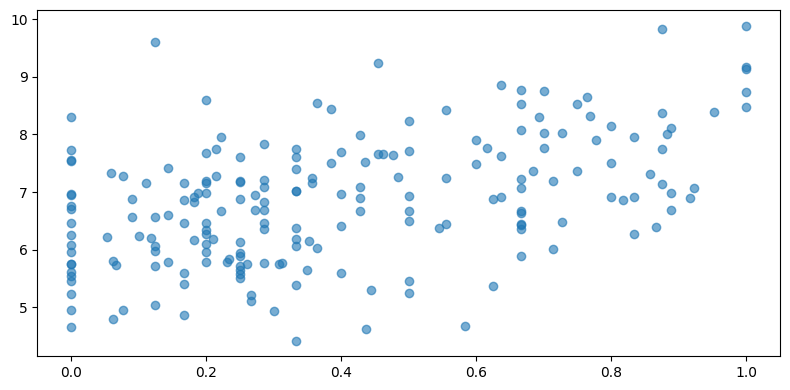

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
plt.tight_layout()
plt.show()

### Linear regression model prediction
The general form of the linear regression prediction function is:

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_{n-1} x_{n-1} + \theta_{n} x_{n}
$$

where $\theta_1 \dots \theta_n$ are weights for the features and $\theta_0$ represents a bias term.

In [16]:
theta = np.random.uniform(size=1 + X.shape[1]).reshape(-1, 1)

In [17]:
theta

array([[0.6447245 ],
       [0.52195747]])

In [18]:
y_hat_0 = theta[0,0] + sum([theta[i+1,0]*X[0, i] for i in range(X.shape[1])])
y_hat_0

np.float64(0.9926961513619585)

Let's rewrite the function in its vector form

$$
\hat{y} = \theta^T \cdot \mathbf{x}
$$

note that we can manage the free bias term by adding a special feature with value 1 to all the items

In [19]:
Xb = np.c_[np.ones((X.shape[0], 1)), X]
Xb[:2]

array([[1.        , 0.66666667],
       [1.        , 0.66666667]])

In [20]:
y_hat_0 = theta.T.dot(Xb[0])
y_hat_0

array([0.99269615])

### Geometric interpretation
The model parameters $\theta$ provide the slope and the intercept for the line that fits the points

In [21]:
example_points = np.array([
    [1, X.min()], [1, X.max()]
])
y_prediction = theta.T.dot(example_points.T)

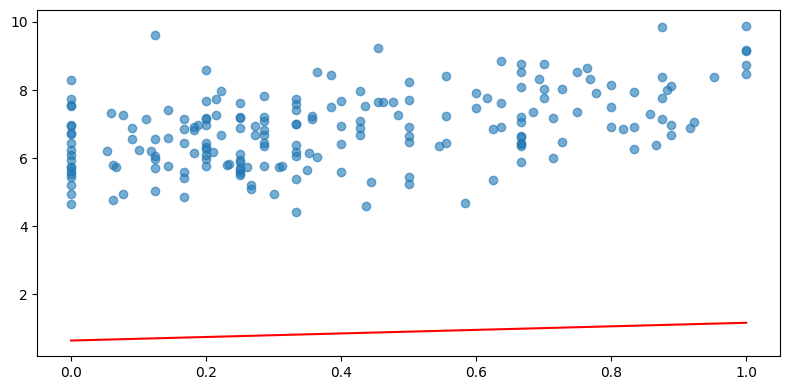

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(example_points[:,1], y_prediction[0], 'r-')
plt.tight_layout()
plt.show()

## Learning the parameters $\theta$

The optimal parameters $\theta$ that map the features $X$ to the target variable $y$ can be computed by a closed-form solution called $Normal Equation$

$$
\hat{\theta} = \left ( \mathbf{X}^T \cdot \mathbf{X} \right )^{-1} \cdot \mathbf{X}^T \cdot y
$$

In [23]:
theta_best = np.linalg.inv(Xb.T.dot(Xb)).dot(Xb.T).dot(y)

In [24]:
theta_best

array([[6.11137224],
       [1.85782123]])

In [25]:
example_points = np.array([
    [1, X.min()], [1, X.max()]
])
y_prediction = theta_best.T.dot(example_points.T)

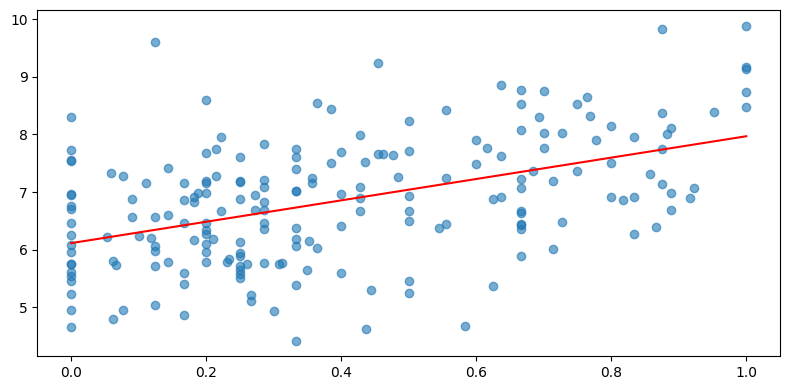

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(example_points[:,1], y_prediction[0], 'r-')
plt.tight_layout()
plt.show()

In [27]:
theta_best

array([[6.11137224],
       [1.85782123]])

### Complexity of the Normal Equation as a solution
The main limit of the normal equation is that it requires to compute the inverse of $\mathbf{X}^T \cdot \mathbf{X}$ that is $n \times n$, where $n$ is the number of features. Inverting such matrix as complexity that may reach $O(n^3)$. Thus, this solution is not suitable with a high number of features.

## Learning $\theta$ by Gradient Descent

As an alternative to compute the optimal values for $\theta$, we can try to learn them by finding the values that minimize the error.

### Compute prediction error by a loss function

As an example of a loss function, we can use Mean Square Error

$$
MSE(\mathbf{X}, \hat{y}) = \frac{1}{m} \sum\limits_{i=1}^{m} \left( \hat{y}^{(i}) - y^{(i)} \right)^2
$$

### Batch gradient descent
Then, we need the gradient of the loss function in order to use it for updating the parameters in the direction of the $MSE$ minimum. To compute the gradient vector, we start from the partial derivative of each parameter $\theta_j$ as follows:

$$
\frac{\partial}{\partial \theta_j} MSE(\theta) = \frac{2}{m} \sum\limits_{i=1}^{m} \left ( \theta^T \cdot \mathbf{x}^{(i)} - y^{(i)} \right ) x_{j}^{(i)}
$$

That is, in vector form:

$$
grad_{MSE} = \frac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \theta - y)
$$

Given $grad_{MSE}$ we just need to subtract it to $\theta$. However, we need to avoid an updating step too big, because we risk to skip the minimum. Thus, let's introduce a learning rate $\eta$ and do training as:

$$
\theta_{i+1} = \theta_i - \eta\ grad_{MSE}(\theta_i)
$$

In [28]:
mse = lambda theta: np.power(theta.T.dot(Xb.T)[0] - y, 2).mean()

In [29]:
eta = .1
iterations = 1000
m = Xb.shape[0]

theta = np.random.uniform(size=(Xb.shape[1], 1))

In [30]:
loss = []
history = []
for iteration in range(iterations):
    loss.append(mse(theta))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration % 20 == 0:
        history.append(theta)

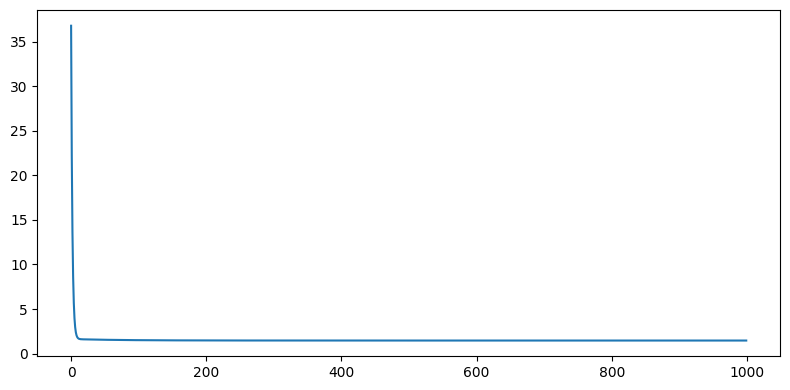

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(loss)
plt.tight_layout()
plt.show()

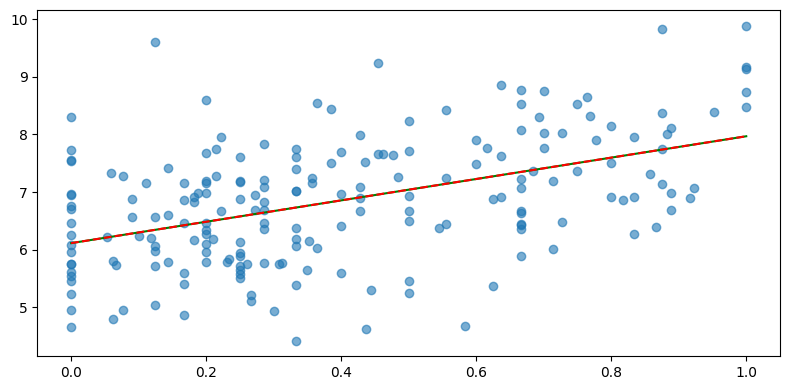

In [32]:
example_points = np.array([
    [1, X.min()], [1, X.max()]
])
y_prediction_best = theta_best.T.dot(example_points.T)
y_prediction = theta.T.dot(example_points.T)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(example_points[:,1], y_prediction_best[0], 'g-')
ax.plot(example_points[:,1], y_prediction[0], 'r--')
plt.tight_layout()
plt.show()

In [33]:
from IPython.display import clear_output
import time

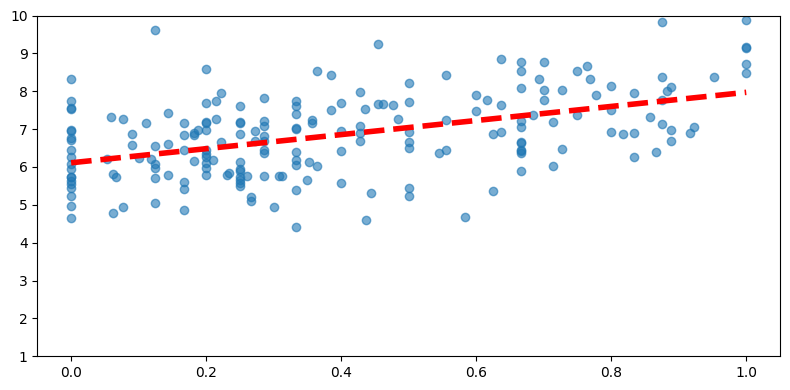

In [34]:
example_points = np.array([[1, X.min()], [1, X.max()]])
predictions = []
for th in history:
    predictions.append(th.T.dot(example_points.T))

cmd = None
for pred in predictions:
    if cmd == 'quit':
        break
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(X, y, alpha=.6)
    ax.plot(example_points[:,1], pred[0], 'r--', linewidth=4)
    ax.set_ylim((1,10))
    plt.tight_layout()
    plt.show()
    cmd = input()

## Exploit Linear regression for binary classification
In order to address binary classification, a very simple strategy is to just change the target variable in a categorical variable. In our case, we set $y \in \{-1, 1\}$, with $-1$ if the recipes is not from the selected cuisine and $1$ otherwise.

In [35]:

sample_size = 200
X, y = np.zeros((sample_size, 1)), np.ones((sample_size, 1))
for i, recipe in enumerate(data[:sample_size]):
    ingredients = recipe['ingredients']
    X[i,0] = len([x for x in ingredients if x in specific_ingredients]) / len(ingredients)
    if recipe[label_field] != cuisine:
        y[i] = -1

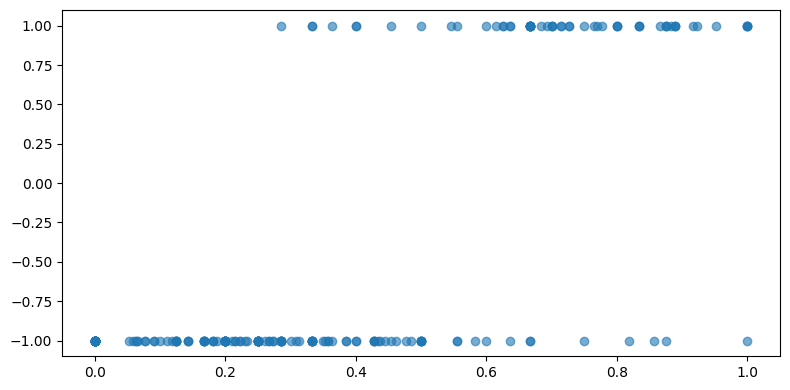

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
plt.tight_layout()
plt.show()

In [37]:
eta = 0.1
iterations = 1000
m = Xb.shape[0]
theta = np.random.uniform(size=(Xb.shape[1], 1))
loss = []
history = []
for iteration in range(iterations):
    loss.append(mse(theta))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration % 20 == 0:
        history.append(theta)

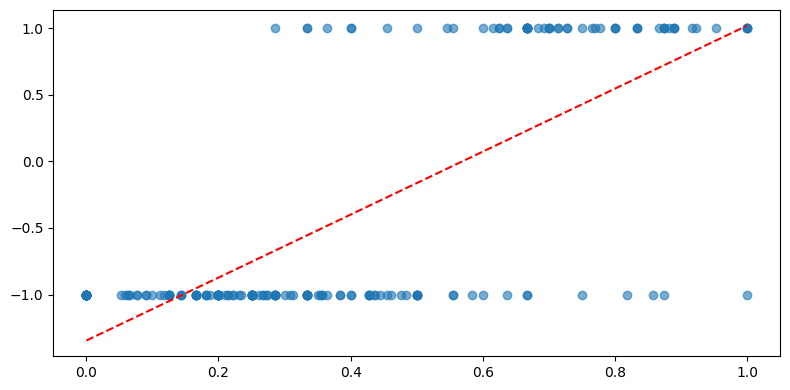

In [38]:
example_points = np.array([[1, X.min()], [1, X.max()]])
y_prediction = theta.T.dot(example_points.T)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(example_points[:,1], y_prediction[0], 'r--')
plt.tight_layout()
plt.show()

In [39]:
y_prediction

array([[-1.3455235 ,  1.01724406]])

### Other algorithm for gradient descent

Batch gradient descent is not the only option for training. In order to avoid exploring the whole dataset to estimate the gradients, have a look at two important options:
- **Stocastic Gradient Descent**: computes the gradient of the parameters using only a single or a few training items by sampling.
- **Mini-batch Gradient Descent**: used often in combination with SGD works of small subsets of the trainin items. Working on minibatches instead of single items reduces the variance in the parameter update and can lead to more stable convergence.

## Work with more features

Now, instead of trying to predict the class observing the number of cuisine-specific ingredients, we encode the recipe ingredients into one-hot encoding vectors in order to work with more features.

Note that the only thing that changes is the shape of the $\mathbf{X}$ matrix.

In [40]:
sample_size = 200
vocabulary = list(pd.Series(document_frequency).sort_values(ascending=False).head(100).keys().values)
X, y = np.zeros((sample_size, len(vocabulary))), np.ones((sample_size, 1))
for i, recipe in enumerate(data[:sample_size]):
    ingredients = recipe['ingredients']
    for ingredient in ingredients:
        try:
            X[i, vocabulary.index(ingredient)] = 1
        except ValueError:
            pass
    if recipe[label_field] != cuisine:
        y[i] = -1

In [41]:
Xb = np.c_[np.ones((X.shape[0], 1)), X]
Xb.shape

(200, 101)

In [42]:
eta = 0.1
iterations = 1000
m = Xb.shape[0]
theta = np.random.uniform(size=(Xb.shape[1], 1))
loss = []
history = []
for iteration in range(iterations):
    loss.append(mse(theta))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration % 20 == 0:
        history.append(theta)

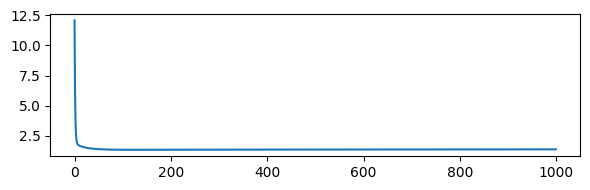

In [43]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(loss)
plt.tight_layout()
plt.show()

**note**: we use a transformation function (i.e., sign) to map predictions on binary labels

In [44]:
y_hat = theta.T.dot(Xb.T)[0]
np.sign(y_hat[:10])

array([ 1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.])

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(Xb)

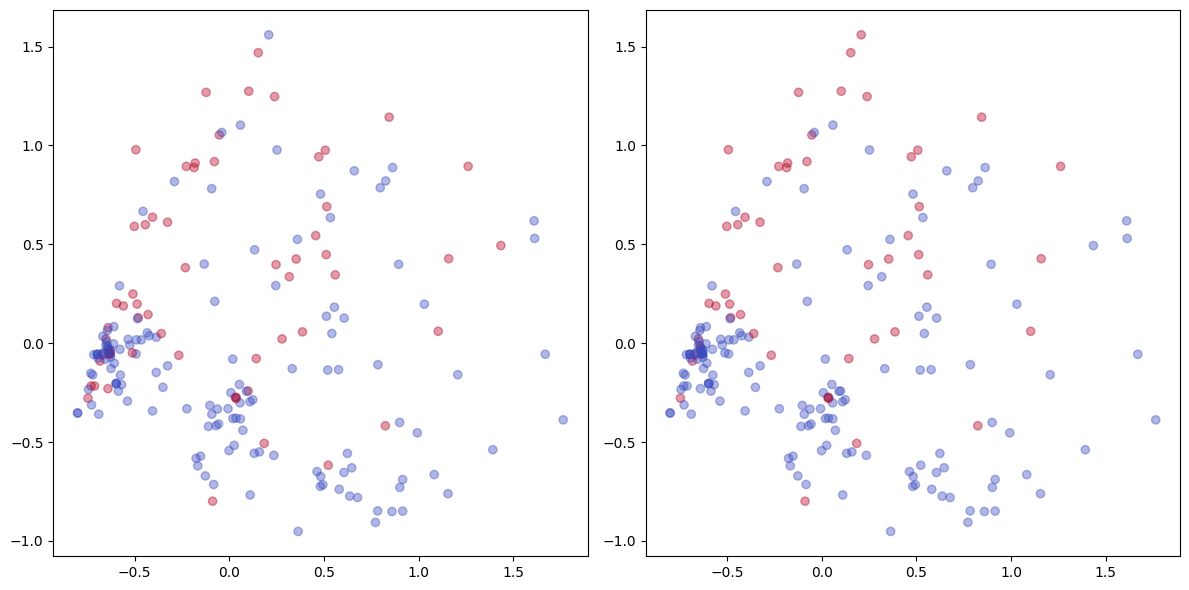

In [47]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].scatter(Xpca[:,0], Xpca[:,1], alpha=.4, c=y, cmap='coolwarm')
ax[1].scatter(Xpca[:,0], Xpca[:,1], alpha=.4, c=np.sign(y_hat), cmap='coolwarm')
plt.tight_layout()
plt.show()

### Evaluation for binary classification

In [48]:
import sklearn.metrics as mt

In [49]:
test_sample_size = 100
X_test, y_test = np.zeros((test_sample_size, len(vocabulary))), np.ones((test_sample_size, 1))
for i, recipe in enumerate(data[sample_size:sample_size + test_sample_size]):
    ingredients = recipe['ingredients']
    for ingredient in ingredients:
        try:
            X_test[i, vocabulary.index(ingredient)] = 1
        except ValueError:
            pass
    if recipe[label_field] != cuisine:
        y_test[i] = -1

In [50]:
Xb_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

In [51]:
y_pred = np.sign(theta.T.dot(Xb_test.T)[0])

In [52]:
print(mt.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.83      0.82      0.83        72
         1.0       0.55      0.57      0.56        28

    accuracy                           0.75       100
   macro avg       0.69      0.70      0.69       100
weighted avg       0.75      0.75      0.75       100



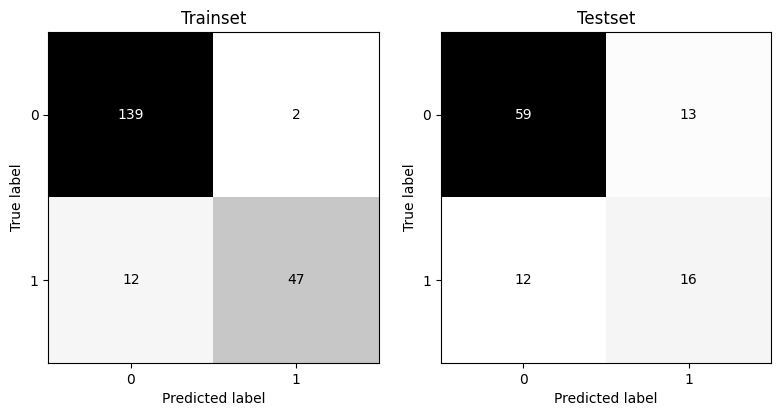

In [53]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2)
cmd_train = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y, np.sign(y_hat)))
cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_test, y_pred))
cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False)
cmd_test.plot(ax=ax[1], cmap='Greys', colorbar=False)
ax[0].set_title('Trainset')
ax[1].set_title('Testset')
plt.tight_layout()
plt.show()

### Learning rates on the training and the test set and the problem of overfitting

In [54]:
test_mse = lambda theta: np.power(theta.T.dot(Xb_test.T)[0] - y_test, 2).mean()

In [55]:
eta = 0.2
iterations = 5000
m = Xb.shape[0]
theta = np.random.uniform(size=(Xb.shape[1], 1))
loss, accuracy = [], []
test_loss, test_accuracy = [], []
for iteration in range(iterations):
    loss.append(mse(theta))
    test_loss.append(test_mse(theta))
    accuracy.append(mt.accuracy_score(y, np.sign(theta.T.dot(Xb.T)[0])))
    test_accuracy.append(mt.accuracy_score(y_test, np.sign(theta.T.dot(Xb_test.T)[0])))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients

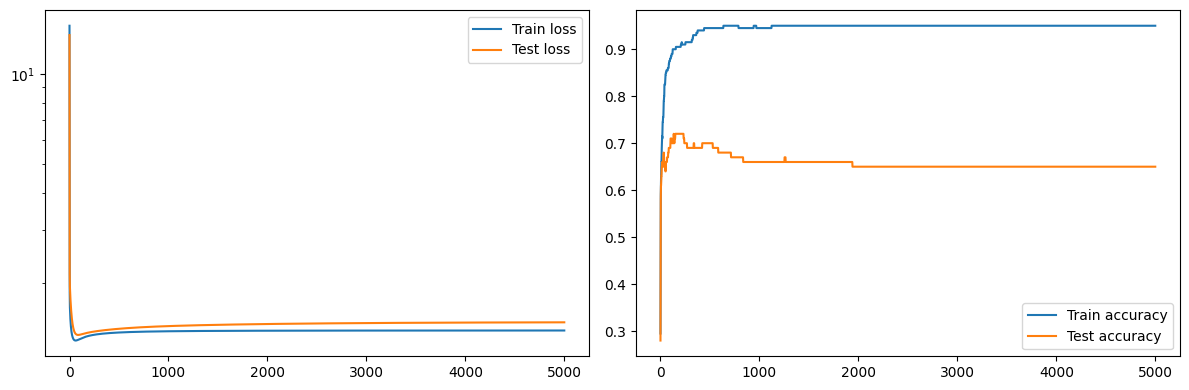

In [56]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].plot(loss, label='Train loss')
ax[0].plot(test_loss, label='Test loss')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].plot(accuracy, label='Train accuracy')
ax[1].plot(test_accuracy, label='Test accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

**Idea**. Use the mapping to categorical values in the training process.

## Logistic regression

The main idea of logistic regression is to estimate a probability for the target class as follows:

$$
\hat{p} = \sigma(\theta^T \cdot \mathbf{X})
$$

where $\sigma(\cdot)$ is a sigmoid function, such as:

$$
\sigma(j) = \frac{1}{1 + exp(-j)}
$$

The output $\hat{p}$ is interpreted as a probability that we can map on $\hat{y}$ as follows:

$$
\hat{y} = \Big\{  \begin{array}{ccc}
-1 & if & \hat{p} < 0.5 \\
1 & if & \hat{p} \geq 0.5
\end{array}
$$

### Loss function
The cost in training for an item can be estimated as (**log loss**):

$$
\ell(\theta) = \Big\{  \begin{array}{ccc}
-\log{\hat{p}} & if & y = 1 \\
-\log{1 - \hat{p}} & if & y = -1
\end{array}
$$

That is general is rewritten with $y \in {0, 1}$ as

$$
\ell(\theta) = - \frac{1}{m} \sum\limits_{i=1}^{m} \left[ y^{(i)} \log \left( \hat{p}^{(i)} \right) + 
(1 - y^{(i)}) \log \left( 1 - \hat{p}^{(i)} \right) \right]
$$

with partial derivates

$$
\frac{\partial}{\partial \theta_j} \ell(\theta) = \frac{1}{m} \sum\limits_{i=1}^{m} 
\left( \sigma \left( \theta^T - \mathbf{x}^{(i)} \right) - y^{(i)} \right) x_j^{(i)}
$$


In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
sample_size = 200
X, y = np.zeros((sample_size, 1)), np.ones((sample_size, 1))
for i, recipe in enumerate(data[:sample_size]):
    ingredients = recipe['ingredients']
    X[i,0] = len([x for x in ingredients if x in specific_ingredients]) / len(ingredients)
    if recipe[label_field] != cuisine:
        y[i] = 0

In [59]:
logistic = LogisticRegression()
logistic.fit(X, y.ravel())

LogisticRegression()

In [60]:
fake_data = np.linspace(0, 1, X.shape[0]).reshape(-1, 1)
probs = logistic.predict_proba(fake_data)

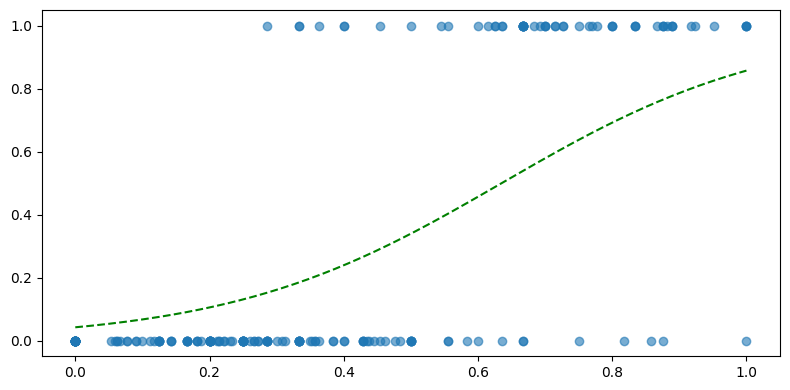

In [61]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(fake_data, probs[:,1], 'g--')
plt.tight_layout()
plt.show()

### A different vectorization process
We want to vectorize documents as vectors of the same size than classes
- for each recipe $x$ and for each ingredient $i$ we compute the probability of $i$ to be in all the classes.
- sum up the probability values per class
- create a vector over the classes for the recipe

In [62]:
sample_size = 200
class_vocabulary = list(cuisine_frequency.keys())
X, y = np.zeros((sample_size, len(class_vocabulary))), np.ones((sample_size, 1))
for i, recipe in enumerate(data[:sample_size]):
    ingredients = recipe['ingredients']
    prob_index = defaultdict(lambda: 0)
    for ingr in ingredients:
        for class_label in class_vocabulary:
            p_i = cuisine_frequency[class_label][ingredient] / sum(cuisine_frequency[class_label].values())
            prob_index[class_label] += p_i
    for class_label, score in prob_index.items():
        X[i, class_vocabulary.index(class_label)] = score
    if recipe[label_field] != cuisine:
        y[i] = 0

In [63]:
logistic = LogisticRegression()
logistic.fit(X, y.ravel())

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept


LogisticRegression()

In [64]:
y_pred = logistic.predict(X)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [65]:
print(mt.classification_report(y.ravel(), y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.70      1.00      0.83       141
         1.0       0.00      0.00      0.00        59

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.50      0.70      0.58       200



## Support Vector Machine (intuition)

The basic idea of SVM is to learn a prediction that is featured by the largest margin from the classes.

Recall that $\theta^T \mathbf{x} = 0$ (including the bias term) is the equation of the hiperplane that separates the data and that we can use the hyperplane for classification by computing

$$
\hat{y} = sign(\theta^T \mathbf{x})
$$

However, we can have several different hyperplanes which serve to the same goal by $\lambda \theta$ for $\lambda \in \mathbb{R}^{+}$. We can thus define a *canonical hyperplane* as the one that separates the point with a *functional distance* of at least 1.

$$
\mathbf{x}_i \cdot \theta \geq 1\ \textrm{if}\ y_i = 1 \newline
\mathbf{x}_i \cdot \theta \leq -1\ \textrm{if}\ y_i = -1 \newline
$$

or

$$
y_i(\mathbf{x}_i \cdot \theta) \geq 1
$$

Note that the notion of functional distance is referred to the resul value of the classification function, not to the geometric margin. The geomeric distance of the margin is given by:

$$
\frac{y_i(\mathbf{x}_i \cdot \theta)}{\mid\mid \theta \mid\mid} \geq \frac{1}{\mid\mid \theta \mid\mid}
$$

The goal of finding an optimal margin is thus to find a boundary that maximizes the geometric distance to the closest data points. This can be obtained by minimizing $\mid\mid \theta \mid\mid$.

In other terms, we want to minimize $\mid\mid \theta \mid\mid$ without violating the margin constraints $y_i(\mathbf{x}_i \cdot \theta) \geq 1$. Moreover, we express the minimization problem as follows:

$$
\textrm{minimize} \ \frac{1}{2} \theta^T \cdot \theta \newline
\textrm{subject to} \ y_i(\mathbf{x}_i \cdot \theta) \geq 1
$$

Note that we use $\frac{1}{2} \theta^T \cdot \theta$ instead of $\mid\mid \theta \mid\mid$ because it has a simple derivative.

### Online SVM
We can address the problem by gradient descent using the following loss function.

$$
\ell(\theta) = \frac{1}{2} \theta^T \cdot \theta + C \sum\limits_{i=1}^{m} \max\left( 0, 1 - y^{(i)} \left( \theta^T \mathbf{x}^{(i)} \right) \right)
$$
where $C$ is a hyperparameter for balancing. The first sum push the model to find a small $\theta$ to have a larger margin. The second sum compute the total of all margin violation. Minimizing this function means to find a large margin by minimizing the number of violations.

## Perceptron
We have seen how we can generalize the idea of linear classification by the following equation:

$$
\hat{y} = g(\theta^T \cdot \mathbf{X})
$$

where $g(\cdot)$ is a function that maps the predicted value to the target variable. This idea can be graphically represented as follows:

![](../imgs/perceptron.jpg)

![](../imgs/perceptron-example.jpg)

## Neural networks
Perceptron can be easily generalized to handle multi-class problems as the in following image. Note that the only main change is in the dimensionality of $\theta$. Given $k$ classes, we will have $\theta \in \mathbb{R}^{n \times k}$. 

In [66]:
a = np.array([1,0,0,1,0,1])
th = np.array([.4, .2, 0, .6, .1, .8])
a.dot(th)

np.float64(1.7999999999999998)

In [67]:
a = np.array([1,0,0,1,0,1])
th = np.array([[.4, .2, 0, .6, .1, .8], [.4, .2, 0, .6, .1, .0]])
a.dot(th.T)

array([1.8, 1. ])

![](../imgs/ffn.jpg)

In [68]:
1 / (1 + np.exp(-np.array([1.8, 1])))

array([0.85814894, 0.73105858])

![](../imgs/ffn-example.jpg)

### Main activation functions

In [69]:
import numpy as np
import matplotlib.pyplot as plt

In [70]:
activation = {
    'identity': lambda x: x,
    'sign': lambda x: np.sign(x),
    'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
    'ReLU': lambda x: np.array([max([k, 0]) for k in x]),
    'tahn': lambda x: (np.exp(2*x) - 1) / (np.exp(2*x) + 1),
    'hard tahn': lambda x: np.array([max([min([k, 1]), -1]) for k in x])
}
data = np.linspace(-5, 5)

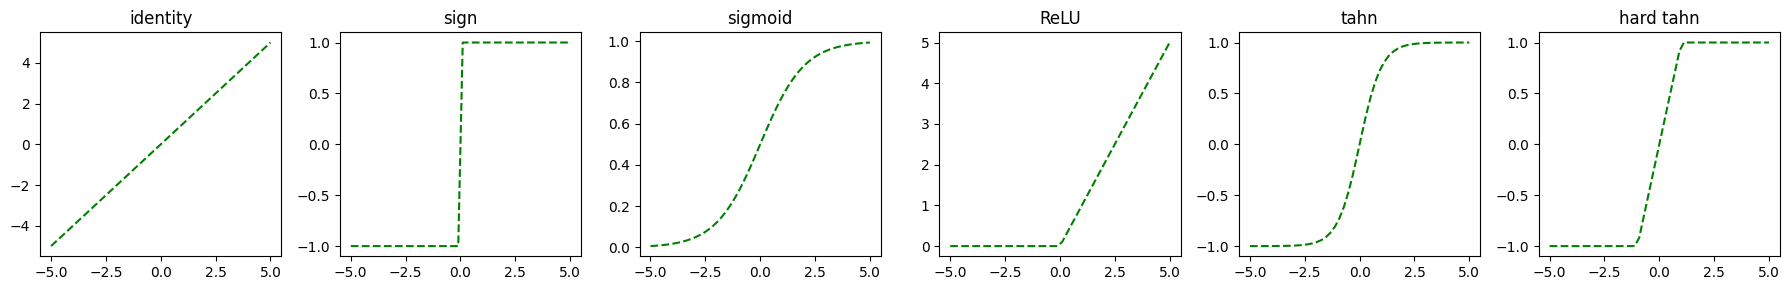

In [71]:
fig, ax = plt.subplots(figsize=(3*len(activation), 3), ncols=len(activation))
for i, (fun, f) in enumerate(activation.items()):
    ax[i].plot(data, f(data), 'g--')
    ax[i].set_title(fun)
plt.tight_layout()
plt.show()

### Simple feedforward network using PyTorch

Predict the cuisine given the combination of ingredients.

In [72]:
from sklearn.preprocessing import OneHotEncoder

In [73]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

In [74]:
train_data = data[:5000]
test_data = data[5000:6000]

In [75]:
vocabulary = list(pd.Series(document_frequency).sort_values(
    ascending=False).head(1000).keys().values)

In [76]:
enc_labels = OneHotEncoder(handle_unknown='ignore')

In [77]:
def get_data(data, vocabulary):
    features, labels = [], []
    for recipe in data:
        features.append([f for f in recipe['ingredients'] if f in vocabulary])
        labels.append([recipe[label_field]])
    return features, labels

In [78]:
train_docs, train_labels = get_data(train_data, vocabulary)
test_docs, test_labels = get_data(test_data, vocabulary)

In [79]:
train_labels[:2]

[['italian'], ['italian']]

In [80]:
X_train = np.zeros((len(train_docs), len(vocabulary)))
for i, doc in enumerate(train_docs):
    for ingredient in doc:
        X_train[i, vocabulary.index(ingredient)] = 1
y_train = enc_labels.fit_transform(np.array(train_labels)).toarray()

In [81]:
X_test = np.zeros((len(test_docs), len(vocabulary)))
for i, doc in enumerate(test_docs):
    for ingredient in doc:
        X_test[i, vocabulary.index(ingredient)] = 1
y_test = enc_labels.transform(np.array(test_labels)).toarray()

In [82]:
X_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [83]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Torch data loader

In [84]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [85]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=10)

In [86]:
for (x, y) in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([10, 1000]) torch.Size([10, 7])


In [87]:
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=10)

### The simple Net

In [88]:
import torch.nn as nn
import torch.nn.functional as F

In [89]:
class SimpleNet(nn.Module):

    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = F.softmax(self.fc(x), dim=0)
        return x

In [90]:
net = SimpleNet(X_train.shape[1], y_train.shape[1])

In [91]:
for (x, y) in train_dataloader:
    p = net(x)
    break

In [92]:
p.shape

torch.Size([10, 7])

In [93]:
p[0]

tensor([0.0908, 0.0972, 0.1012, 0.1063, 0.0889, 0.1047, 0.1020],
       grad_fn=<SelectBackward0>)

### Train

In [94]:
import time
import math

In [95]:
batches = [(doc, lab) for doc, lab in train_dataloader]
read_labels = [x.replace('x0_', '') for x in enc_labels.get_feature_names_out()]

In [96]:
def train(document_tensor, label_tensor, criterion, learning_rate):
    net.zero_grad()
    output = net(document_tensor)
    loss = criterion(output, label_tensor)
    loss.backward()

    for p in net.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [97]:
n_iters = 20000
print_every = 2000
plot_every = 200
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.1

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

epochs = list(range(1, n_iters + 1))
for it in tqdm(epochs):
    document_tensor, label_tensor = batches[np.random.randint(0, len(batches) - 1)]
    output, loss = train(document_tensor, label_tensor, criterion, learning_rate)
    current_loss += loss

    if it % print_every == 0:
        preds = torch.argmax(output, dim=1)
        ground = torch.argmax(label_tensor, dim=1)
        for i, p in enumerate(preds[:3]):
            g = ground[i]
            print('{} ==> {}'.format(read_labels[p], read_labels[g]))

    if it % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  0%|          | 0/20000 [00:00<?, ?it/s]

italian ==> italian
chinese ==> chinese
southern ==> mexican
mexican ==> mexican
indian ==> indian
italian ==> italian
italian ==> italian
greek ==> greek
greek ==> greek
italian ==> italian
italian ==> italian
mexican ==> mexican
mexican ==> mexican
indian ==> indian
mexican ==> mexican
southern ==> indian
chinese ==> indian
italian ==> southern
southern ==> southern
southern ==> southern
chinese ==> southern
italian ==> italian
polish ==> southern
chinese ==> italian
greek ==> southern
greek ==> mexican
mexican ==> mexican
chinese ==> southern
italian ==> italian
italian ==> italian


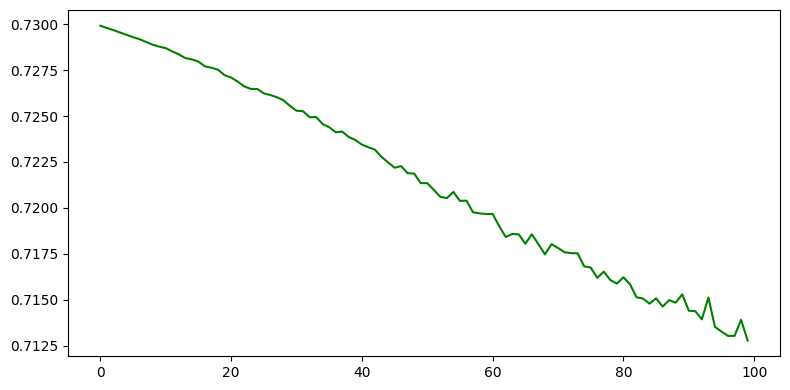

In [98]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(all_losses, 'g')
plt.tight_layout()
plt.show()

### Prediction on train

In [99]:
y_pred_train, y_true_train = [], []
for doc, lab in train_dataloader:
    output = net(doc)
    preds = torch.argmax(output, dim=1)
    ground = torch.argmax(lab, dim=1)
    for i, p in enumerate(preds):
        y_pred_train.append(p)
        g = ground[i]
        y_true_train.append(g)

In [100]:
print(mt.classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.41      0.81      0.55       383
           1       0.36      0.54      0.43       338
           2       0.49      0.66      0.57       538
           3       0.76      0.51      0.61      1309
           4       0.72      0.58      0.64      1186
           5       0.04      0.11      0.06        62
           6       0.56      0.47      0.51      1184

    accuracy                           0.55      5000
   macro avg       0.48      0.53      0.48      5000
weighted avg       0.61      0.55      0.57      5000



### Prediction on test

In [101]:
y_pred, y_true = [], []
for doc, lab in test_dataloader:
    output = net(doc)
    preds = torch.argmax(output, dim=1)
    ground = torch.argmax(lab, dim=1)
    for i, p in enumerate(preds):
        y_pred.append(p)
        g = ground[i]
        y_true.append(g)

In [102]:
print(mt.classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.37      0.74      0.49        77
           1       0.26      0.36      0.30        72
           2       0.32      0.55      0.41        85
           3       0.77      0.51      0.61       265
           4       0.67      0.55      0.60       211
           5       0.07      0.16      0.10        19
           6       0.52      0.39      0.45       271

    accuracy                           0.49      1000
   macro avg       0.42      0.47      0.42      1000
weighted avg       0.56      0.49      0.51      1000



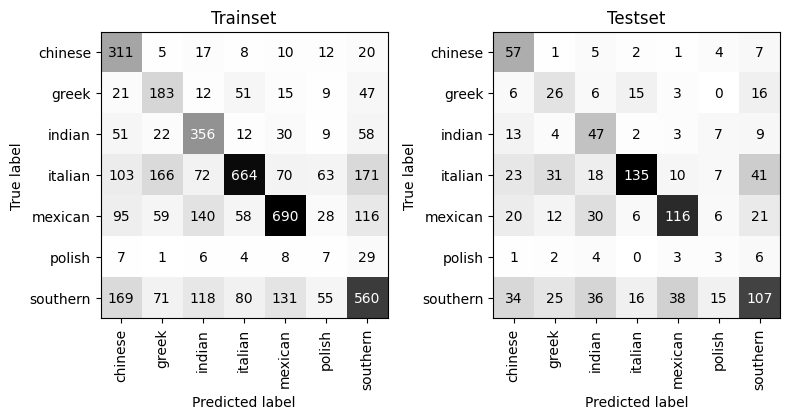

In [103]:
fig, ax = plt.subplots(figsize=(8, 6), ncols=2)
cmd_train = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_true_train, y_pred_train), 
                                      display_labels=read_labels)
cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_true, y_pred), 
                                     display_labels=read_labels)
cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False, xticks_rotation='vertical')
cmd_test.plot(ax=ax[1], cmap='Greys', colorbar=False, xticks_rotation='vertical')
ax[0].set_title('Trainset')
ax[1].set_title('Testset')
plt.tight_layout()
plt.show()

## Some considerations about network parameters

In [104]:
print([x for x in net.named_parameters()])

[('fc.weight', Parameter containing:
tensor([[-0.1144, -0.1911, -0.2948,  ..., -0.0287, -0.0073,  0.0141],
        [-0.0058, -0.1115,  0.5827,  ..., -0.0291, -0.0257,  0.0060],
        [ 0.7686,  0.1545, -0.2839,  ..., -0.0083, -0.0095,  0.0091],
        ...,
        [-0.2779,  0.4004, -0.2992,  ...,  0.0443,  0.0025, -0.0286],
        [ 0.0029,  0.0177, -0.0524,  ..., -0.0058, -0.0215,  0.0196],
        [ 0.2329, -0.0278, -0.5773,  ...,  0.0119,  0.0043,  0.0128]],
       requires_grad=True)), ('fc.bias', Parameter containing:
tensor([ 0.0029,  0.0166,  0.0002, -0.0134, -0.0281, -0.0111, -0.0066],
       requires_grad=True))]


In [105]:
params = {name: param.detach().numpy() for name, param in net.named_parameters()}

In [106]:
params['fc.weight'].shape

(7, 1000)

**Note** that we have 6 classes and 1000 features in this dataset. Thus, we can associate one 6 value vector to each feature. Let's try:

In [107]:
feature_vectors = pd.DataFrame(params['fc.weight'].T, index=vocabulary, columns=labels)
feature_vectors

,italian,indian,southern,mexican,chinese,greek,polish
salt,-0.114415,-0.005817,0.768597,-0.243318,-0.277943,0.002896,0.232884
onion,-0.191109,-0.111466,0.154478,-0.018182,0.400400,0.017695,-0.027772
olive oil,-0.294770,0.582739,-0.283914,0.968949,-0.299158,-0.052424,-0.577271
garlic cloves,0.129494,0.121936,0.060721,0.327741,0.012703,-0.053468,-0.394736
water,0.270387,-0.095635,0.290821,-0.160103,-0.216591,0.066043,-0.085273
...,...,...,...,...,...,...,...
chili-garlic sauce,0.057018,-0.017795,-0.025555,-0.027241,-0.025503,0.006183,-0.024495
self rising flour,-0.012118,0.000036,-0.027515,-0.012945,0.005634,-0.002164,0.041320
reduced-fat sour cream,-0.028743,-0.029068,-0.008281,-0.027575,0.044339,-0.005791,0.011864
fish,-0.007341,-0.025735,-0.009463,0.011019,0.002465,-0.021472,0.004306


Now, let's try computing ingredient similarity by this vectors

In [108]:
from sklearn.metrics.pairwise import cosine_similarity

In [109]:
sigma = cosine_similarity(feature_vectors, feature_vectors)
S = pd.DataFrame(sigma, index=vocabulary, columns=vocabulary)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [110]:
S.head()

,salt,onion,olive oil,garlic cloves,water,butter,sugar,eggs,garlic,parmesan cheese,...,flank steak,cheese tortellini,fresh sage leaves,coleslaw mix,hot pepper flakes,chili-garlic sauce,self rising flour,reduced-fat sour cream,fish,dried chilies
salt,1.000000,0.064778,-0.389598,-0.294608,0.610475,0.282798,0.319404,-0.021103,-0.070464,-0.324212,...,-0.166581,0.017385,0.359858,0.009177,0.376202,-0.255851,-0.181015,-0.095106,-0.259934,0.429557
onion,0.064778,1.000000,-0.263806,-0.074507,-0.314720,-0.306908,-0.688945,-0.514858,-0.313210,-0.198725,...,0.243912,-0.035323,-0.445876,0.301878,-0.216141,-0.568981,-0.024643,0.766180,0.170119,-0.676993
olive oil,-0.389598,-0.263806,1.000000,0.745535,-0.383107,-0.169445,-0.483975,0.016537,0.625158,0.825814,...,-0.124527,0.224592,-0.251794,-0.162797,0.095871,-0.229937,-0.365957,-0.564924,-0.030470,-0.013445
garlic cloves,-0.294608,-0.074507,0.745535,1.000000,0.057849,-0.703226,-0.470372,-0.540732,0.900974,0.653238,...,0.172869,0.453295,-0.337357,0.468489,-0.130414,0.086330,-0.809990,-0.551139,-0.076163,-0.113857
water,0.610475,-0.314720,-0.383107,0.057849,1.000000,-0.195854,0.592413,-0.292281,0.337012,-0.280178,...,-0.017721,0.195787,0.326121,0.456025,-0.000585,0.557113,-0.530263,-0.409706,-0.337674,0.577256


In [119]:
query = 'cucumber'
S.loc[query].sort_values(ascending=False).head(10)

cucumber             1.000000
feta                 0.945172
feta cheese          0.920520
greek yogurt         0.914119
semolina             0.886625
dill                 0.850774
sweet chili sauce    0.822202
orange zest          0.821936
kalamata olive       0.808545
red wine vinegar     0.793545
Name: cucumber, dtype: float32

In [112]:
k_sigma = cosine_similarity(feature_vectors.T, feature_vectors.T)
K = pd.DataFrame(k_sigma, index=labels, columns=labels)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [113]:
K

,italian,indian,southern,mexican,chinese,greek,polish
italian,1.000000,-0.176511,0.044736,-0.234188,-0.203316,-0.049373,-0.115867
indian,-0.176511,1.000000,-0.138730,0.176248,-0.185176,-0.056485,-0.197079
southern,0.044736,-0.138730,1.000000,-0.331229,-0.094963,-0.047868,-0.143928
mexican,-0.234188,0.176248,-0.331229,1.000000,-0.351562,-0.040105,-0.309141
chinese,-0.203316,-0.185176,-0.094963,-0.351562,1.000000,-0.094978,-0.272755
greek,-0.049373,-0.056485,-0.047868,-0.040105,-0.094978,1.000000,0.173735
polish,-0.115867,-0.197079,-0.143928,-0.309141,-0.272755,0.173735,0.999999


In [116]:
K.loc['mexican'].sort_values(ascending=False)

mexican     1.000000
indian      0.176248
greek      -0.040105
italian    -0.234188
polish     -0.309141
southern   -0.331229
chinese    -0.351562
Name: mexican, dtype: float32